| | |
|:----------|:----------|
| Name      | Bayesian Linear Regression |
| Author    | Joshuah Touyz, PhD |
| Version   | 1.0 |
|Last update| 02/13/20 |

### Linear regression using PyMC3

In [5]:

# Import PyMC3
from pymc3 import  *

# -- Load libraries --
# Data manipulation libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd

# Plotting libaries
import plotnine as pn
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt


# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

### Simple Bayesian Linear regression
Suppose we have the setup

\begin{align}
Y = \beta_0 + \beta_1 x +\xi \qquad \begin{bmatrix}\beta_0\\ \beta_1\end{bmatrix}\sim MVN\left(\mu=\begin{bmatrix}0\\0\end{bmatrix} ,10\cdot I_{2\times 2}\right)\qquad \xi\sim IG(\alpha = 1,\beta = 3)
\end{align}

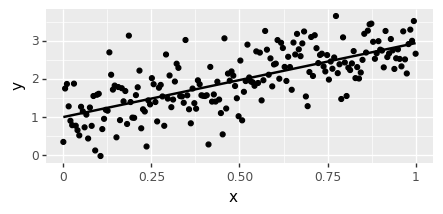

<ggplot: (-9223372036519609270)>

In [6]:
pn.options.figure_size=(5,2)
pn.options.dpi= 100
# True values
n = 200
beta_0 = 1
beta_1 = 2
x = np.linspace(0, 1, n)

# Setting up linear equation
# Mean function
mu = beta_0 + beta_1 * x

# Add noise
y = mu + np.random.normal(scale=.5, size=n)

# Setting up data
df = pd.DataFrame({'x':x,'y':y})

# True value
ggplot(aes(x = 'x',y = 'y'),data = df) + geom_point() +    geom_smooth(aes(x = 'x',y = 'y'),method='lm', se=False)

#### Specifying the model: approach 1 - likelihood

In [7]:
# Instantiate base model
model = Model()

with model:
    # Define priors
    sigma2 = InverseGamma('sigma2', alpha = 1, beta=4, testval=1.)
    intercept = Normal('beta_0', 0, sigma=10)
    x_coeff = Normal('beta_1', 0, sigma=10)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, sigma=sigma2, observed=y)

    # Inference!
    trace = sample(3000, cores=2) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, sigma2]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:03<00:00, 2195.30draws/s]
The acceptance probability does not match the target. It is 0.8791322394554707, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
a = pd.DataFrame(trace['beta_1']).rename({0:'value'},axis = 1)
a.head()

,value
0,1.860794
1,1.825055
2,1.769246
3,2.049587
4,2.217639


#### Specifying the model: approach 2 - patsy like formula

In [9]:
model2 = Model()

with model2:
    # Specify the glm and pass in data with 'patsy' equation
    glm.GLM.from_formula('y ~ x',  df)
    trace2 = sample(3000, cores=2) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:03<00:00, 2134.61draws/s]


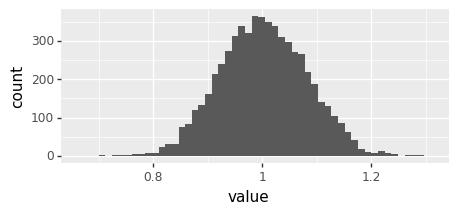

<ggplot: (335657273)>

In [10]:
# Samples from `model`
a = pd.DataFrame(trace['beta_0']).rename({0:'value'},axis = 1)
ggplot(aes(x ='value'), data  = a) + geom_histogram()

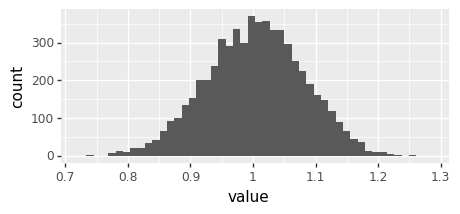

<ggplot: (335584688)>

In [11]:
# Samples from `model2`
a2 = pd.DataFrame(trace2['Intercept']).rename({0:'value'},axis = 1)
ggplot(aes(x ='value'), data  = a2) + geom_histogram()

#### MCMC Diagnostics
- Gelman-Rubin Statistic
- Summary values
- Traceplot

In [12]:
# -- Gelman Rubin Statistic:  Do the chains converge? ---
gelman_rubin(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta_0   float64 1.001
    beta_1   float64 1.001
    sigma2   float64 1.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13fc3b518>,
      dtype=object)

<Figure size 504x504 with 0 Axes>

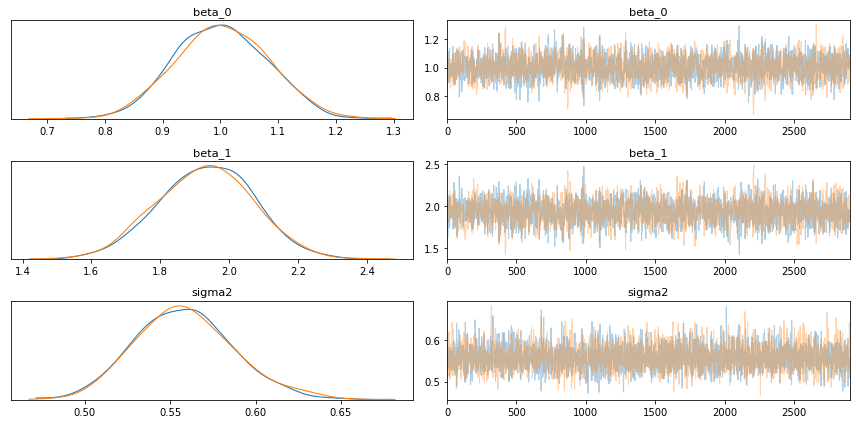

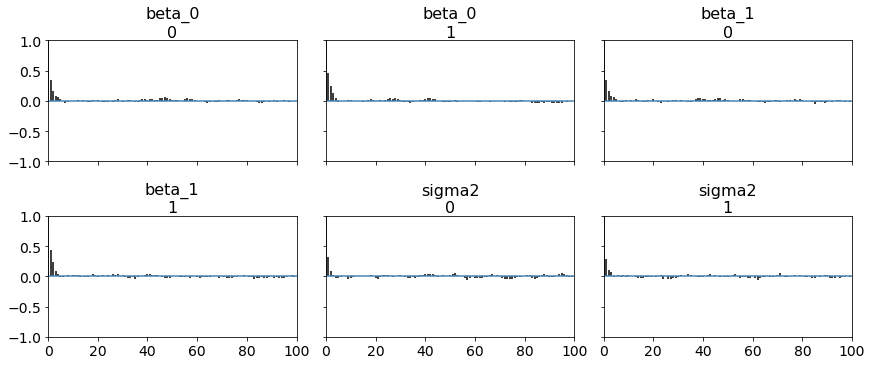

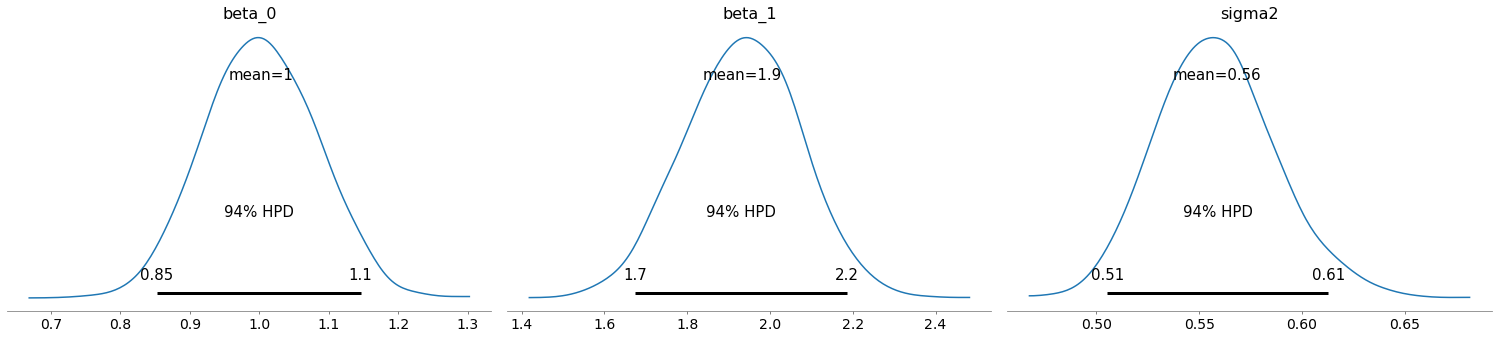

In [13]:
# -- Summary stats ---
summary(trace).round(2)

# -- Traceplot: --
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

# -- Autocorrelation: Does the sampler mix approriately --
a = autocorrplot(trace, figsize=(12,5))
                 
# -- What do the posterior plots look like? --
plot_posterior(trace)

#### Working with the posterior draws
- Getting the posterior draws
- Getting specific values 

In [14]:
# For `model`
df_posterior_draws = trace_to_dataframe(trace)
beta_1_values = trace.get_values('beta_1', burn=1000, chains=[0, 1])
beta_0_values = trace.get_values('beta_0', burn=1000, chains=[0, 1])


# For `model2`
df_posterior_draws_2 = trace_to_dataframe(trace2)
beta_1_values_2 = trace2.get_values('x', burn=1000, chains=[0, 1])
beta_0_values_2 = trace2.get_values('Intercept', burn=1000, chains=[0, 1])


### Plotting the mean distribution
df_posterior_draws = trace_to_dataframe(trace)
beta_1_values = trace.get_values('x', burn=1000, chains=[0, 1])
beta_0_values = trace.get_values('Intercept', burn=1000, chains=[0, 1])

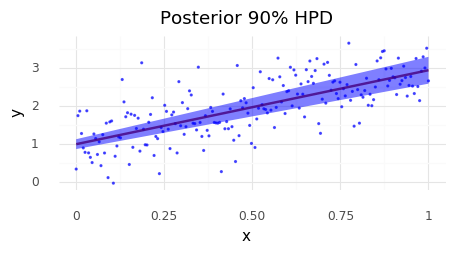

<ggplot: (335704363)>

In [53]:
# Setting up the posterior mean
posterior_hpd = pd.DataFrame({'beta_1':beta_1_values,'beta_0':beta_0_values}).quantile([0.05,0.5,0.95], axis=0)
lower_val =  posterior_hpd.beta_0.values[0] + posterior_hpd.beta_1.values[0]*df['x']
median_val =  posterior_hpd.beta_0.values[1] + posterior_hpd.beta_1.values[1]*df['x']
upper_val =  posterior_hpd.beta_0.values[2] + posterior_hpd.beta_1.values[2]*df['x']
df_mean_ci = pd.DataFrame({'lower_val':lower_val,'median_val':median_val,'upper_val':upper_val,'y':df['y'], 'x':df['x']})

# Plotting the regression lines
ggplot(aes(x = 'x', y = 'y'), data = df_mean_ci)\
+ geom_point(size = 0.3, alpha = 0.6, color='blue')\
+ geom_line(aes(x = 'x',y = 'median_val'), alpha = 0.8, size = 1,color = 'darkred',data = df_mean_ci )\
+ theme_minimal() +ylab('y') + xlab('x')\
+ geom_ribbon(aes(x='x', ymin='lower_val',ymax='upper_val'), data=df_mean_ci, fill="blue", alpha=0.5)\
+ ggtitle('Posterior 90% HPD')

#### Posterior predictive checks
Does `y` fit our expected distribution?
- To calculate the posterior predictive distribution we generate 500 samples for the observed values of $\mathbf{x}_{200\times 1}$
- We then take the average over the 

Generating values from the `model` (notice the priors have a large impact here)

100%|██████████| 500/500 [00:00<00:00, 1161.75it/s]


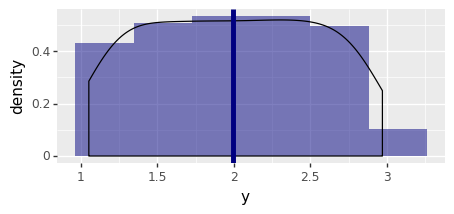

<ggplot: (-9223372036509627469)>

In [145]:
# Generating posterior samples
post_pred = sample_posterior_predictive(trace, samples=500, model=model)
post_pred_dist = post_pred['y'].mean(axis=0)

# Plot method 1
y_post_ave = pd.DataFrame({'y':post_pred_dist})
ggplot(aes(x = 'y'),data = y_post_ave)\
+ geom_histogram(aes(y='stat(density)'),alpha = 0.5, fill = 'navy')\
+ geom_density()\
+ geom_vline(aes(xintercept=y_post_ave.mean()), color = 'navy', size = 2)

Generating samples form `model2`

100%|██████████| 500/500 [00:00<00:00, 1136.68it/s]


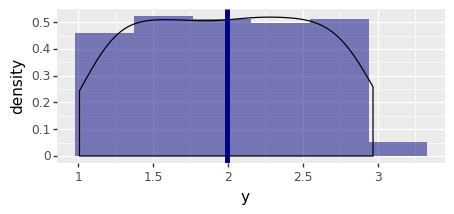

<ggplot: (-9223372036512474985)>

In [146]:
# Generating posterior samples
post_pred = sample_posterior_predictive(trace2, samples=500, model=model2)
post_pred_dist = post_pred['y'].mean(axis=0)

# Plot method 1
y_post_ave = pd.DataFrame({'y':post_pred_dist})
ggplot(aes(x = 'y'),data = y_post_ave)\
+ geom_histogram(aes(y='stat(density)'),alpha = 0.5, fill = 'navy')\
+ geom_density()\
+ geom_vline(aes(xintercept=y_post_ave.mean()), color = 'navy', size = 2)

In [147]:
ci_90 = pd.DataFrame(post_pred['y']).quantile(q=[0.05,0.95], axis=0, numeric_only=True, interpolation='linear').T
ci_90 = ci_90.rename({0.05:'ci_lower',0.95:'ci_upper'},axis=1)
ci_90['x'] = df['x']

#### Plotting the posterior predictive 
- Here we are plotting the 90\% credilbe interval
- Below we plot the set of regression lines that form the envelope of the posterior uncertainty

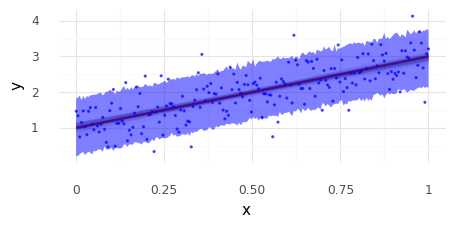

<ggplot: (342210259)>

In [148]:
# Calculating the regression lines
y_post_values = beta_0_values + np.outer(x,beta_1_values) 
y_post_upper = np.amax(y_post_values,axis = 0)
y_post_lower = np.amin(y_post_values,axis = 0)
df_post = pd.DataFrame({'simulation':np.arange(0,len(y_post_lower)) ,
                        0:y_post_lower,
                        1:y_post_upper})
df_post = df_post.loc[0:200,:]
# Posterior regression lines
df_post = df_post.set_index(['simulation']).stack().reset_index().rename({'level_1':'x',0:'value'},axis=1)
true_regression = pd.DataFrame({'x':x,'y':mu})

# Plotting the regression lines
ggplot()\
+ geom_line(aes(x = 'x', y = 'value', group = 'simulation'), alpha = 0.05, color='grey', data = df_post)\
+ geom_point(aes(x = 'x', y = 'y'), size = 0.3, alpha = 0.6, color='blue', data = df)\
+ geom_line(aes(x = 'x',y = 'y'), alpha = 0.8, size = 1,color = 'darkred',data = true_regression )\
+ theme_minimal() +ylab('y') + xlab('x')\
+ geom_ribbon(aes(x='x', ymin='ci_lower',ymax='ci_upper'), data=ci_90, fill="blue", alpha=0.5)

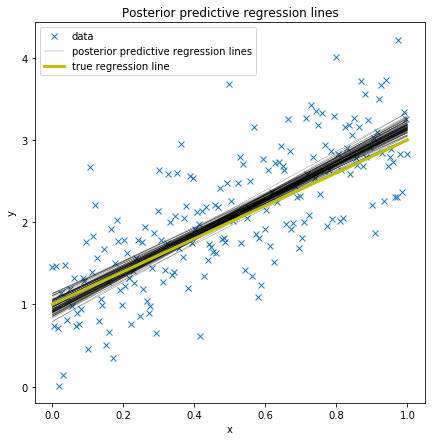

In [21]:
# Using the builtin plotter
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plot_posterior_predictive_glm(trace, samples=100, label='posterior predictive regression lines')
plt.plot(x, mu, label='true regression line', lw=3., c='y')
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');